<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6485 entries, 0 to 6484
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   總價(萬元)    6485 non-null   float64
 1   占比乗面積     6485 non-null   float64
 2   building  6485 non-null   object 
 3   屋齡        6485 non-null   int64  
 4   樓別/樓高     6484 non-null   object 
 5   管理組織      6485 non-null   object 
 6   電梯        6485 non-null   object 
 7   主要用途      6468 non-null   object 
 8   region    6485 non-null   object 
 9   房         6485 non-null   int64  
 10  衛         6485 non-null   int64  
 11  廳         6485 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 608.1+ KB
              總價(萬元)        占比乗面積           屋齡            房            衛  \
count    6426.000000  6426.000000  6426.000000  6426.000000  6426.000000   
mean     1201.641690    37.825715    23.241986     3.162465     1.871304   
std      2377.571178    72.042855    16.443194     1.38

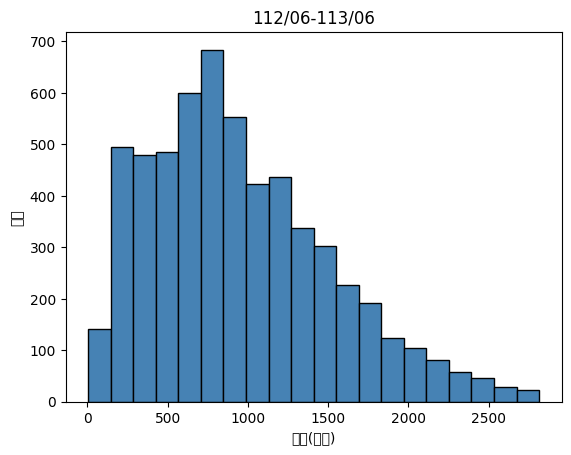

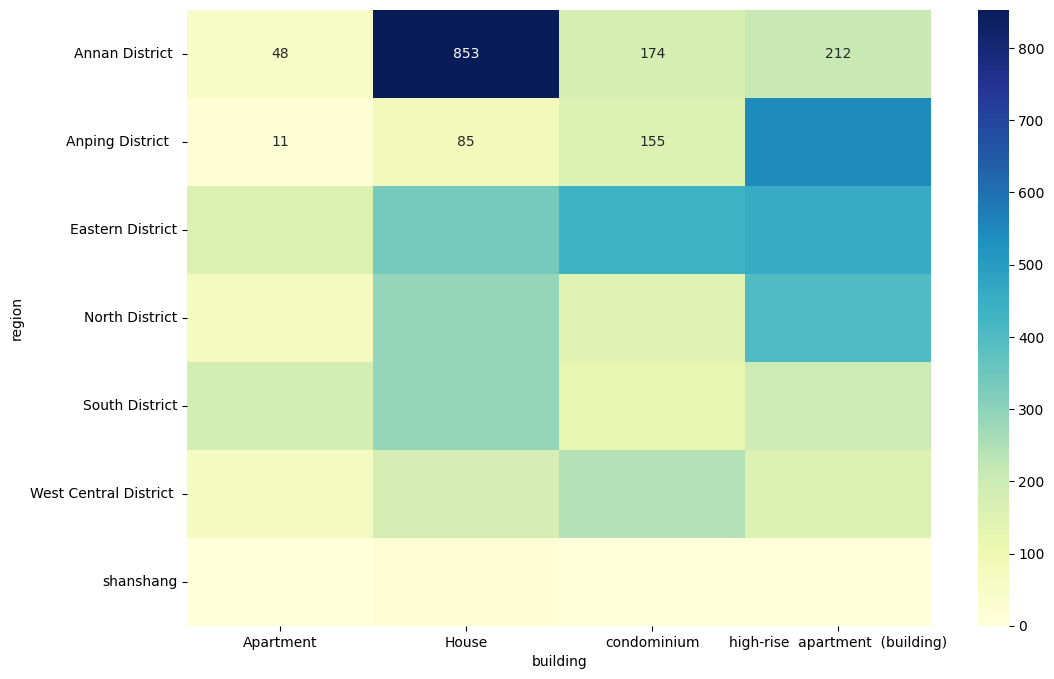

R方得分: 0.7903201591899769


ValueError: Found array with 0 sample(s) (shape=(0, 27)) while a minimum of 1 is required by RandomForestRegressor.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import tkinter as tk
from tkinter import messagebox
# 數據加載
data = pd.read_csv('FINAL.csv')

# 選特徵
data = data[['總價(萬元)', '占比乗面積', 'building', '屋齡', '樓別/樓高', '管理組織', '電梯', '主要用途', 'region','房','衛', '廳']]

# 初步
data.info()

# 删除重複行
data = data.drop_duplicates()

# 填補缺失直
data['主要用途'].fillna('住家用', inplace=True)
data.dropna(subset=['樓別/樓高'], inplace=True)

# 描述分析
print(data.describe())
data['房'] = data['房'].astype(float)
data['廳'] = data['廳'].astype(float)
data['衛'] = data['衛'].astype(float)
# 異常值處理 - 總價(萬元)
s = data['總價(萬元)'].describe()
IQR = s['75%'] - s['25%']
upper_lim = s['75%'] + IQR * 1.5
lower_lim = s['25%'] - IQR * 1.5
data = data[data['總價(萬元)'] < upper_lim]

# 異常值處理 - 占比乗面積
s = data['占比乗面積'].describe()
IQR = s['75%'] - s['25%']
upper_lim = s['75%'] + IQR * 1.5
lower_lim = s['25%'] - IQR * 1.5
data = data[data['占比乗面積'] < upper_lim]

# 更新
print(data.describe())

# 總價(萬元)的直方圖
plt.hist(data['總價(萬元)'], bins=20, color='steelblue', edgecolor='black')
plt.title('112/06-113/06')
plt.xlabel('價格(萬元)')
plt.ylabel('數量')
plt.show()



# 交叉表
cross_table = pd.crosstab(data['region'], data['building'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_table, cmap='YlGnBu', annot=True, fmt='d')
plt.show()

# 拆分樓別/樓高
data['樓別'] = data['樓別/樓高'].str.split('/', expand=True)[0]
data['樓高'] = data['樓別/樓高'].str.split('/', expand=True)[1]
data.drop(['樓別/樓高'], axis=1, inplace=True)

# 樓別和樓高
data['樓別'] = data['樓別'].str.split(',', expand=True)[0]

data['樓別'] = data['樓別'].apply(
    lambda x: '地下' if '地下' in x 
    else '其他' if x in '其他'
    else '全層' if '全' in x 
    else '低層' if x in ['一層', '二層', '三層', '四層', '五層']
    else '中層' if x in ['六層', '七層', '八層', '九層', '十層', '十一層', '十二層', '十三層', '十四層', '十五層']
    else '高層'
)

data['樓高'] = data['樓高'].apply(
    lambda x: '低層' if x in ['一層', '二層', '三層', '四層', '五層']
    else '中層' if x in ['六層', '七層', '八層', '九層', '十層', '十一層', '十二層', '十三層', '十四層', '十五層']
    else '高層'
)

# 
data_encoded = pd.get_dummies(data, columns=['building', '主要用途', 'region'])

# 
code_dict = {'地下': 0, '其他': 1, '低層': 2, '中層': 3, '高層': 4, '全層': 5}
data_encoded['樓別'] = data_encoded['樓別'].map(code_dict)
code_dict = {'低層': 0, '中層': 1, '高層': 2}
data_encoded['樓高'] = data_encoded['樓高'].map(code_dict)
code_dict = {'無': 0, '有': 1}
data_encoded['電梯'] = data_encoded['電梯'].map(code_dict)
data_encoded['管理組織'] = data_encoded['管理組織'].map(code_dict)

# 删除無用列
data_encoded = data_encoded.drop(['主要用途_其他'], axis=1)

# 處理 '屋齡' 缺失值
Age_Na = data_encoded[data_encoded["屋齡"].isnull()]
Age_not_Na = data_encoded[data_encoded["屋齡"].notnull()]

y = Age_not_Na['屋齡']
X = Age_not_Na.drop('屋齡', axis=1)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfModel_age = RandomForestRegressor(n_estimators=100, random_state=42)
rfModel_age.fit(X_train, y_train)

from sklearn.metrics import r2_score
y_pred = rfModel_age.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R方得分:', r2)

# 重置索引
Age_Na = Age_Na.reset_index(drop=True)
Age_not_Na = Age_not_Na.reset_index(drop=True)

#  '屋齡' 缺失值
Age_Na.drop('屋齡', axis=1, inplace=True)
Age_Na_value = rfModel_age.predict(Age_Na)
Age_Na['屋齡'] = Age_Na_value

# 整合數據
data = pd.concat([Age_not_Na, Age_Na], axis=0).sort_index().reset_index(drop=True)

# 模型
y = data['總價(萬元)']
X = data.drop('總價(萬元)', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfModel = RandomForestRegressor(n_estimators=100, random_state=42)
rfModel.fit(X_train, y_train)

y_pred = rfModel.predict(X_test)
r2 = r2_score(y_test, y_pred)
print('R方得分:', r2)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ",round(rmse),'萬')
X.columns
data_encoded.info()

In [4]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Dummy data (replace this with your actual data loading code)
data = pd.read_csv('FINAL.csv')

# Preprocessing
x = data[['屋齡', '占比乗面積']]
y = data['總價(萬元)']
scaler = StandardScaler()
X = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# GUI
def predict_price():
    try:
        # Get inputs from GUI
        age = float(entry_age.get())
        area_ratio = float(entry_area_ratio.get())
        
        # Scale inputs
        input_data = scaler.transform([[age, area_ratio]])
        
        # Predict
        predicted_price = model.predict(input_data)[0]
        
        # Show prediction
        result_label.config(text=f'預測房價: {predicted_price:.2f} 萬元')
        
    except ValueError as e:
        messagebox.showerror('錯誤', '請確保輸入為數字')

# Create GUI window
window = tk.Tk()
window.title('房價預測')
window.geometry('300x200')

# Labels
label_age = ttk.Label(window, text='屋齡:')
label_age.pack(pady=5)
entry_age = ttk.Entry(window)
entry_age.pack()

label_area_ratio = ttk.Label(window, text='占比乗面積:')
label_area_ratio.pack(pady=5)
entry_area_ratio = ttk.Entry(window)
entry_area_ratio.pack()

# Button
predict_button = ttk.Button(window, text='預測房價', command=predict_price)
predict_button.pack(pady=10)

# Result label
result_label = ttk.Label(window, text='')
result_label.pack(pady=10)

# Start GUI
window.mainloop()